In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
from xai import read_data, create_dataframe, compare_experiments, compare_exp_testset
from xai import plot_true_fake_maps, plot_sample_r_vs_k, plot_r_vs_r, plot_all_r_vs_k, plot_r_single_sample
#from xai import read_data, create_dataframe, plot_true_fake_maps

from correlation_coefficient import compute_r

/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [17]:
base_output_dir = "../output/" # Meanwhile I have my own output directory with GAN results
names = ['test', 'xai_exp_only_using_ha', 'xai_exp_only_using_oiii' ]
results_dir = "../output/xai_results/"
nrun = 100
nindex = 1
suffix_list = [ "run{:d}_index{:d}".format(i, j) for i in range(nrun) for j in range(nindex) ]
ref_dir = os.path.join(base_output_dir, names[0])
ha_dir = os.path.join(base_output_dir, names[1])
oiii_dir = os.path.join(base_output_dir, names[2])

Saved plot ../output/xai_results//comparison_of_reconstructed_halpha_signals.png


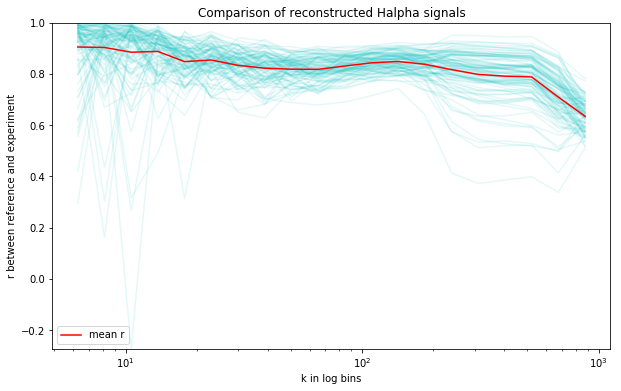

In [68]:
r_mix_list, r_ha_list, r_oiii_list = compare_exp_testset(ref_dir, ha_dir, log_bins=True)
plot_all_r_vs_k(r_ha_list, results_dir, title="Comparison of reconstructed Halpha signals")

## To identify the worst sample with the minimum r the following can work:
#np.min(np.array(r_ha_list[1:]),axis=0) # Returns the r values for the sample with the lowest r
#yolo = np.array(r_ha_list[1:]) # Store the array instead of list
#min_index = np.unravel_index(np.argmin(yolo), yolo.shape) returns the index, the first value of the tuple is the runXX
#min_index

Saved plot ../output/xai_results//comparison_of_reconstructed_oiii_signals.png


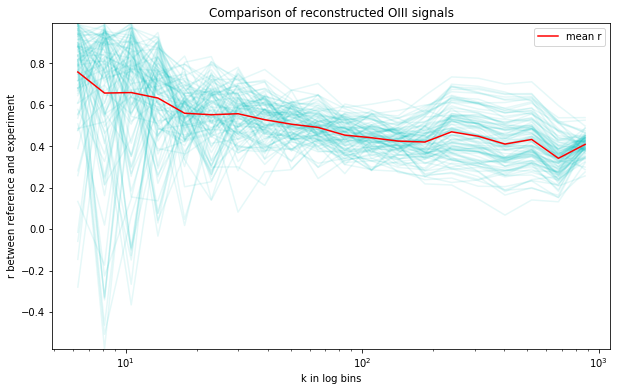

In [6]:
r_mix_list, r_ha_list, r_oiii_list = compare_exp_testset(ref_dir, oiii_dir, log_bins=True)
plot_all_r_vs_k(r_oiii_list, results_dir, title="Comparison of reconstructed OIII signals")

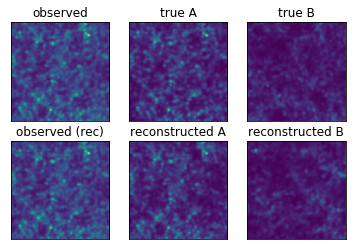

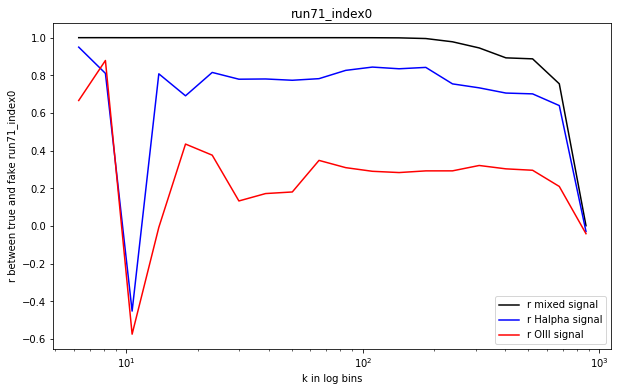

In [67]:
suffix=f"run71_index0"
data_ref = read_data(ref_dir, suffix=suffix, ldict=False)
plot_true_fake_maps(data_ref, results_dir)
data_ref = read_data(ref_dir, suffix=suffix, ldict=True)
plot_r_single_sample(data_ref, suffix, log_bins=True)

ha


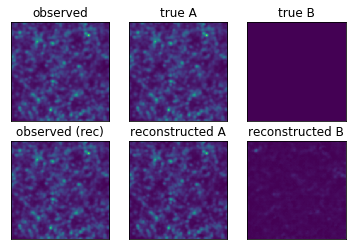

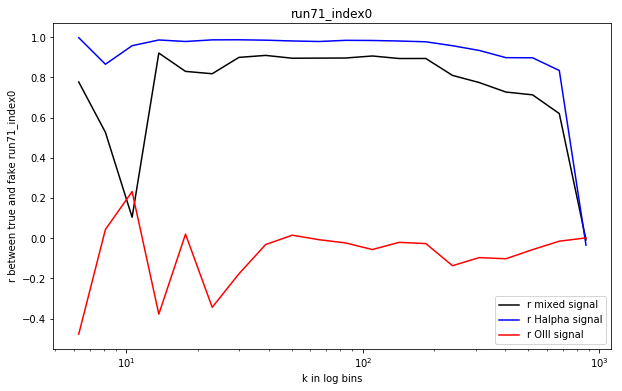

In [65]:
data_ha = read_data(ha_dir, xai_exp='ha', suffix=suffix, ldict=False)
plot_true_fake_maps(data_ha, results_dir)
data_ha = read_data(ha_dir, suffix=suffix, ldict=True)
plot_r_single_sample(data_ha, suffix, log_bins=True)

oiii


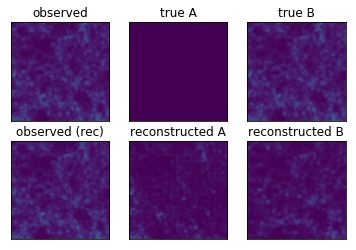

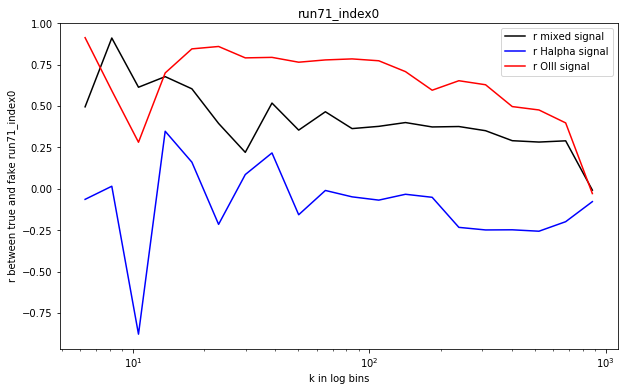

In [66]:
data_oiii = read_data(oiii_dir, xai_exp='oiii', suffix=suffix, ldict=False)
plot_true_fake_maps(data_oiii, results_dir)
data_oiii = read_data(oiii_dir, suffix=suffix, ldict=True)
plot_r_single_sample(data_oiii, suffix, log_bins=True)

In [27]:
    container = {}
    for d in names:
        output_dir = os.path.join(base_output_dir, d)
        if not os.path.exists(output_dir):
            print(f"Output directory {output_dir} does not exist.")
            print("The ouput directory stores the output of the GAN needed as input for XAI.")
            exit()
        df, k = create_dataframe(output_dir, nrun, nindex)
        container[d] = df

In [49]:
df_ref = container[names[0]]

In [51]:
df_ref.r_ha_10.mean()

0.8533143740074146

In [58]:
df_ref.loc[df_ref['sample_id'] == 'run71_index0']["r_ha_10"]

71   -0.452599
Name: r_ha_10, dtype: float64